In [39]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM,MaxPooling1D,Dropout,Activation,Embedding,RepeatVector,TimeDistributed,Conv2D,MaxPooling2D,Flatten,Convolution2D
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from keras import metrics
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint
import pprint
from keras.callbacks import Callback
from matplotlib import pyplot
from numpy import array

from sklearn import metrics
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [40]:
df = pd.read_csv('h_train_sm.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,45.0,1.0,1.521928,Aria
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,40.0,0.0,0.000000,Aria
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3.0,0.0,3.0,1.0,60.0,0.0,0.000000,Aria


In [41]:

X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data
X.shape

(270000, 25)

In [42]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [43]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)


In [44]:
y

array([ 0,  0,  0, ..., 26, 26, 26])

In [45]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [46]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [47]:
#Train test validation split - 60:20:20
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)


In [48]:
X_train.shape

(216000, 25)

In [49]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train,( X_train.shape[0], 5, 5))
X_val = np.reshape(X_val,( X_val.shape[0], 5, 5))

In [50]:
# reshape input to be [samples, time steps, features]
Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0],  Y_val.shape[1]))

In [51]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [52]:
X_train.shape

(216000, 5, 5)

In [61]:
# Embedding
max_features = X_train[0]
maxlen = 25
embedding_size = 50

# Convolution
kernel_size = 5
filters = 128
pool_size = 4

# LSTM
lstm_output_size = 27
number_of_units=25
model_FileName = "long_mc_bestWeightsLSTMStateless3L50.hdf5"
Batch_size = 10
randomInit = initializers.RandomUniform(seed=42)
lr=0.002
Epochs=30
dropout=1
# Training
batch_size = 30
epochs = 20

In [62]:
model = Sequential()
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1,input_shape=(5, 5)))
model.add(MaxPooling1D(pool_size=pool_size, padding='same'))
model.add(LSTM(number_of_units, kernel_initializer = randomInit, bias_initializer = randomInit,))
model.add(Dense(27))
model.add(Activation('softmax'))

nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])




hdf5FileName = "long_mc_bestWeightsLSTMStateless3L50.hdf5"
checkpoint = ModelCheckpoint(hdf5FileName,monitor='val_acc',verbose=1,save_best_only=True,mode='max',save_weights_only=True)

start_time = time.time()



history=model.fit(X_train, Y_train, epochs=50, batch_size=100, verbose=2, shuffle=False,
            validation_data = (X_val,Y_val),callbacks=[checkpoint,es])  

print("--- %s seconds ---" % (time.time() - start_time))

from keras.models import load_model

model.save(hdf5FileName[:-3])  # creates a HDF5 file 'my_model.h5'



Train on 216000 samples, validate on 54000 samples
Epoch 1/50
 - 10s - loss: 2.7111 - acc: 0.1801 - val_loss: 2.4569 - val_acc: 0.2428

Epoch 00001: val_acc improved from -inf to 0.24276, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 2/50
 - 8s - loss: 2.3200 - acc: 0.2663 - val_loss: 2.2057 - val_acc: 0.2922

Epoch 00002: val_acc improved from 0.24276 to 0.29220, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 3/50
 - 8s - loss: 2.1113 - acc: 0.3210 - val_loss: 2.0344 - val_acc: 0.3163

Epoch 00003: val_acc improved from 0.29220 to 0.31628, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 4/50
 - 8s - loss: 1.9597 - acc: 0.3641 - val_loss: 1.8999 - val_acc: 0.3666

Epoch 00004: val_acc improved from 0.31628 to 0.36656, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 5/50
 - 8s - loss: 1.8261 - acc: 0.4089 - val_loss: 1.7652 - val_acc: 0.4201

Epoch 00005: val_acc improved from 0.36656 to 0.42009, saving model to long_mc_

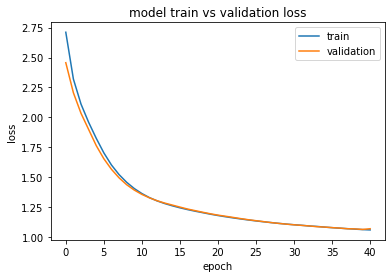

In [66]:

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')




pyplot.show()

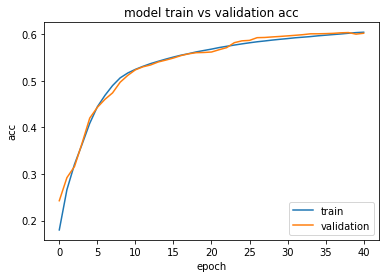

In [67]:

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

## Test

In [71]:
df = pd.read_csv('h_test_sk.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria
1,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,765,1,5.567481,Aria
2,0,0,0,1,0,0,1,0,29200,1,...,0,0,4,0,1,2,48,0,0.000000,Aria
3,1,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0.000000,Aria
4,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria


In [73]:
## 
X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data



from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)



from keras.utils import np_utils
y = np_utils.to_categorical(y)


# reshape input to be [samples, time steps, features]
X_test = np.reshape(X, (X.shape[0], 1, X.shape[1]))



# reshape input to be [samples, time steps, features]
Y_test = np.reshape(y, (y.shape[0],  y.shape[1]))



# reshape input to be [samples, time steps, features]
X_test = np.reshape(X_test,( X_test.shape[0], 5, 5))


In [74]:
Y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## TEST DEĞERLENDİRME

In [75]:
loss,acc = model.evaluate(X_test,Y_test,batch_size=1)
print("Loss for testing = {} and Accuracy for testing = {}".format(loss,acc))
#predicted = model.predict(X_test)

81000/81000 [==============================] - 71s 879us/step
Loss for testing = 1.1287237929923037 and Accuracy for testing = 0.590283950617284


In [77]:
predicted = model.predict(X_test)



In [78]:
predicted

array([[9.9948031e-01, 3.2795964e-11, 9.9084390e-16, ..., 1.1164400e-14,
        4.4168232e-12, 5.3104161e-09],
       [9.9855655e-01, 1.1505689e-07, 4.6990656e-13, ..., 1.5874932e-14,
        7.6827728e-10, 1.6904464e-07],
       [1.1928317e-01, 5.9296726e-05, 2.3031623e-06, ..., 2.7193965e-03,
        2.8126258e-03, 4.0033352e-01],
       ...,
       [4.8290196e-01, 6.6648026e-05, 5.4534720e-08, ..., 7.1628602e-07,
        4.4617831e-04, 4.1973680e-01],
       [1.7518127e-01, 1.0589157e-02, 5.2286116e-05, ..., 5.0771341e-05,
        2.4887961e-05, 3.7625748e-01],
       [4.8296487e-01, 6.6546185e-05, 5.4492638e-08, ..., 7.1594434e-07,
        4.4608369e-04, 4.1968960e-01]], dtype=float32)

In [79]:
(X_test.shape)

(81000, 5, 5)

In [80]:
#predicted = model.predict(X_test)

In [81]:
(predicted.shape)

(81000, 27)

In [82]:
"""

for i in X_test:
    temp=i
    print(temp.shape) #(predicted)
    temp=(np.reshape(temp, (temp.shape[0], 1, temp.shape[1])))
    print(temp.shape) #(predicted)
    predicted = model.predict(temp,batch_size=1000)
    print(predicted)
    break
"""

'\n\nfor i in X_test:\n    temp=i\n    print(temp.shape) #(predicted)\n    temp=(np.reshape(temp, (temp.shape[0], 1, temp.shape[1])))\n    print(temp.shape) #(predicted)\n    predicted = model.predict(temp,batch_size=1000)\n    print(predicted)\n    break\n'

### grafik mırafik

In [83]:
def compute_metrics(predicted, Y_test):   
    Y_classes = [np.argmax(item) for item in Y_test]
    #print(Y_classes)
    predicted_classes = [np.argmax(item) for item in predicted]
    predictions = np.array(predicted_classes)
    Y_actual = np.array(Y_classes)
   
    y_actu = pd.Series(np.reshape(Y_actual,len(Y_actual)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=list(range(0,27)))
    y_pre = pd.Categorical(y_pred, categories=list(range(0,27)))
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = list(range(0,27)))))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    
    predicted= np.array(predicted).tolist()
    Y_test = np.array(Y_test).tolist()

    n_classes = 27
    print("n_classes is: ", n_classes)
    Y_test= np.asarray(Y_test)
    predicted = np.asarray(predicted)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [84]:
predicted

array([[9.9948031e-01, 3.2795964e-11, 9.9084390e-16, ..., 1.1164400e-14,
        4.4168232e-12, 5.3104161e-09],
       [9.9855655e-01, 1.1505689e-07, 4.6990656e-13, ..., 1.5874932e-14,
        7.6827728e-10, 1.6904464e-07],
       [1.1928317e-01, 5.9296726e-05, 2.3031623e-06, ..., 2.7193965e-03,
        2.8126258e-03, 4.0033352e-01],
       ...,
       [4.8290196e-01, 6.6648026e-05, 5.4534720e-08, ..., 7.1628602e-07,
        4.4617831e-04, 4.1973680e-01],
       [1.7518127e-01, 1.0589157e-02, 5.2286116e-05, ..., 5.0771341e-05,
        2.4887961e-05, 3.7625748e-01],
       [4.8296487e-01, 6.6546185e-05, 5.4492638e-08, ..., 7.1594434e-07,
        4.4608369e-04, 4.1968960e-01]], dtype=float32)

In [85]:
print(predicted.shape, Y_test.shape)

(81000, 27) (81000, 27)


Average F1 score is 0.5863956640550712
Confusion matrix: 
 Predicted    0     1     2     3     4    5   6    7     8     9   ...    17  \
Actual                                                             ...         
0          2282     0     0     0     0    0   0    0     0     0  ...   380   
1             1  2142   100     0     5  120  11   40   289    32  ...    29   
2            19     0  2503     0     0    0   0    0     0   212  ...    81   
3            32     0    61  2827     0    0   0    0    22     0  ...     0   
4             6   182     6     0  1675  138  18  431   142     0  ...    11   
5            15   150    22     5   290  556  88  794   763     8  ...    21   
6             4   145    25     7   164  562  95  871   808    11  ...    12   
7             7   150    13     3   455  507  88  379  1098    11  ...     9   
8             8   137    21    21   211  515  85  835   850    11  ...     8   
9            41     0   549     0     0    0   0    0     0  

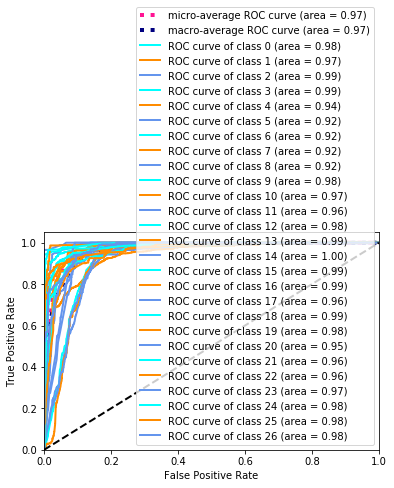

In [86]:
compute_metrics(predicted, Y_test)

In [87]:
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))

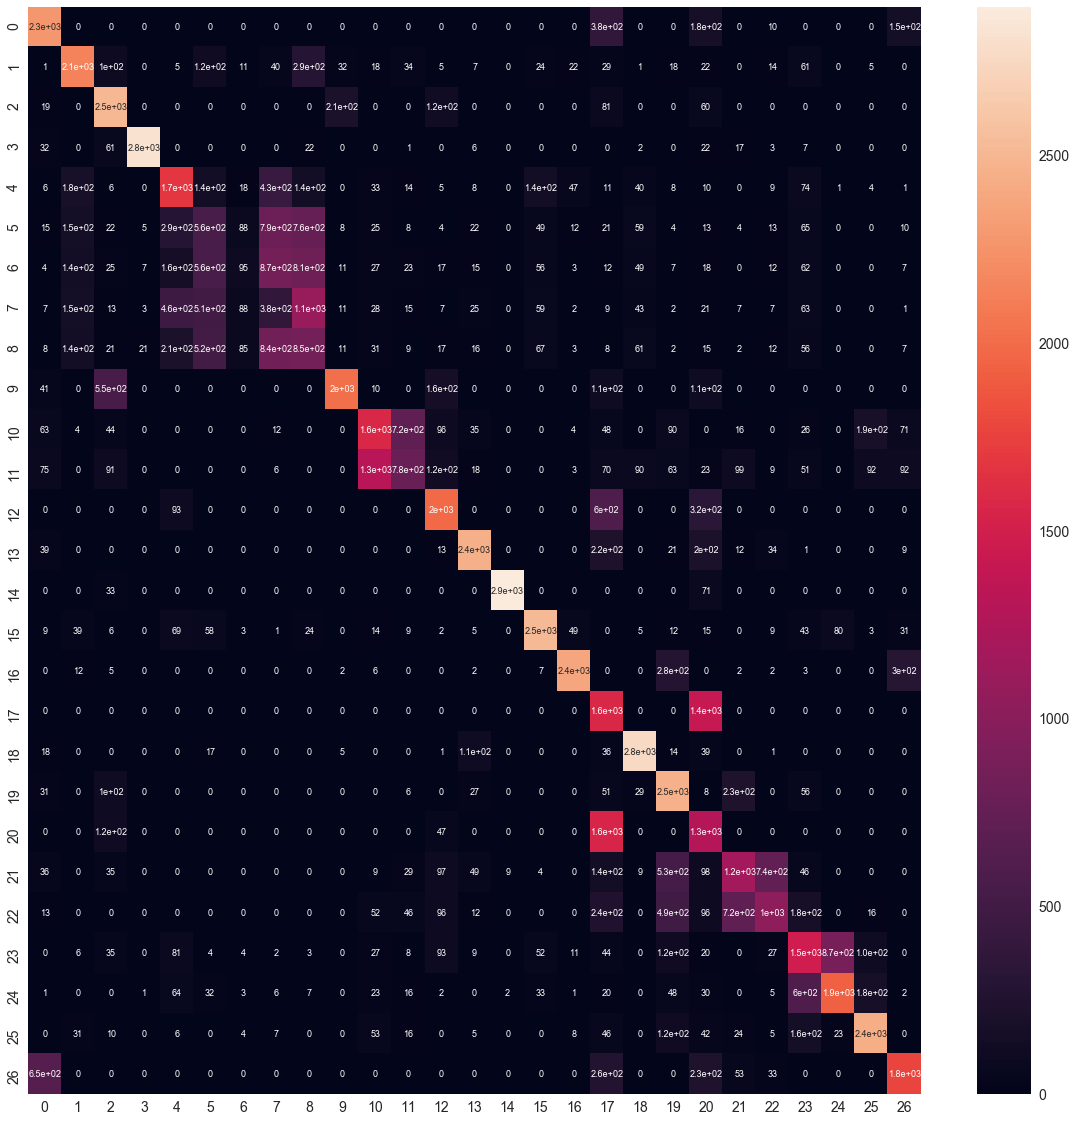

In [88]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



df_cm = pd.DataFrame(matrix, range(27), range(27))
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

In [91]:
cm=matrix
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall fscore")
for label in range(27):
    pr=precision(label, cm)
    rec=recall(label, cm)
    f1=2*(pr*rec/(pr+rec))
    print(f"{label:5d} {pr:9.3f} {rec:6.3f} {f1:6.3f}")

label precision recall fscore
    0     0.681  0.761  0.719
    1     0.714  0.714  0.714
    2     0.661  0.834  0.738
    3     0.987  0.942  0.964
    4     0.538  0.558  0.548
    5     0.222  0.185  0.202
    6     0.238  0.032  0.056
    7     0.112  0.126  0.119
    8     0.212  0.283  0.243
    9     0.874  0.674  0.761
   10     0.486  0.527  0.506
   11     0.448  0.258  0.328
   12     0.686  0.663  0.674
   13     0.868  0.815  0.840
   14     0.996  0.965  0.981
   15     0.837  0.838  0.838
   16     0.935  0.794  0.859
   17     0.283  0.525  0.368
   18     0.877  0.919  0.897
   19     0.574  0.820  0.675
   20     0.292  0.426  0.347
   21     0.499  0.393  0.440
   22     0.525  0.346  0.417
   23     0.488  0.492  0.490
   24     0.664  0.643  0.653
   25     0.805  0.814  0.809
   26     0.721  0.589  0.648


## MODEL SAVING RELOADING

In [89]:
from keras.models import load_model

model.save('54.h5')  # creates a HDF5 file 'my_model.h5'



In [90]:

# returns a compiled model
# identical to the previous one
model = load_model('54.h5')